In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

INPUT = '/scratch/users/k21075402/new'
harvest = {
    'name': 'commons_harvest__open',
    'TRIAL_IDS_SP': ['39596646', '3f82a7f6', 'b484e613', 'd1a59a0e', 'ebcd23ed'],
    'TRIAL_IDS_ID': ['41697eb3', '68238f61', 'b0569bd9', 'd1ec3174', 'eb100aee']
}
mushroom = {
    'name': 'externality_mushrooms__dense',
    # 'TRIAL_IDS_ID': ['ec5de638']}
    'TRIAL_IDS_ID': ['8de7e630', 'ab15db82', 'b7c04d31', 'ca8d5c9d', 'cb2f86c9']
}

window = 21
epochs = 300

In [2]:
def load_df(trial_id: str, *, environment: dict[str], independent: bool=False, num_players: int=None, self_interest: float=None):
    df = pd.read_json(os.path.join(INPUT, environment['name'], trial_id, 'results.json'), lines=True)
    df['reward'] = df.episode_reward.apply(lambda x: np.mean(x))
    df['trial_id'] = trial_id
    assert num_players is None or self_interest is None, 'Can only select based on either num_players or self_interest'
    if num_players is not None:
        df = df[(df['num_players'] == num_players)]
        df = df.sort_values(by=['self-interest', 'training_iteration'], ascending=[False, True])
        df = df.reset_index(drop=True)
        df['iteration'] = df.index + 1
    elif self_interest is not None:
        df = df[(df['self-interest'] == self_interest)]
        df['iteration'] = df.training_iteration + 300 * (df.num_players - 1)
    
    df = df.drop(columns=['training_iteration', 'episode_reward', 'episode_lengths'])
    if independent:
        df = df.drop(columns=df.filter(regex='policy_player_').columns)
    else:
        df = df.drop(columns=['policy_default_reward'])
    return df

In [3]:
def plot_num_players(df, rolling: bool = False):
    grouped = df.groupby('trial_id')

    # Plot each group
    fig, ax = plt.subplots(figsize=(12, 5), facecolor='white')
    for name, group in grouped:
        if rolling:
            result = group['reward'].rolling(window=window, center=True).mean()
            indices = [list(range(epochs*i - window//2 + 1, epochs*i + window//2 +1)) for i in range(1, 7)]
            result.iloc[indices] = np.nan
            result.plot(ax=ax, label=name, legend=False, lw=0.75)
        else:
            group.plot(x='iteration', y='reward', ax=ax, label=name, legend=False, lw=0.75)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Social welfare')
    ax.set_xlim(0, 2100)
    ax.set_ylim(0, 900)
    ax.set_xticks(np.arange(0, 2101, 300))
    ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='grey', alpha=0.5)
    ax.xaxis.grid(True, color='grey', linestyle='--', alpha=0.5)
    
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())  # Make sure the limits are the same
    ax2.set_yticks(ax.get_yticks())  # Duplicate the tick marks
    
    regions = dict((str(i), i * 300) for i in range(1,8))
    
    for region, position in regions.items():
        # ax.axvline(x=position, color='gray', linestyle='--', alpha=0.5)
        ax.text(position-150, 1.02, region, transform=ax.get_xaxis_transform(), horizontalalignment='center')

    return fig, ax

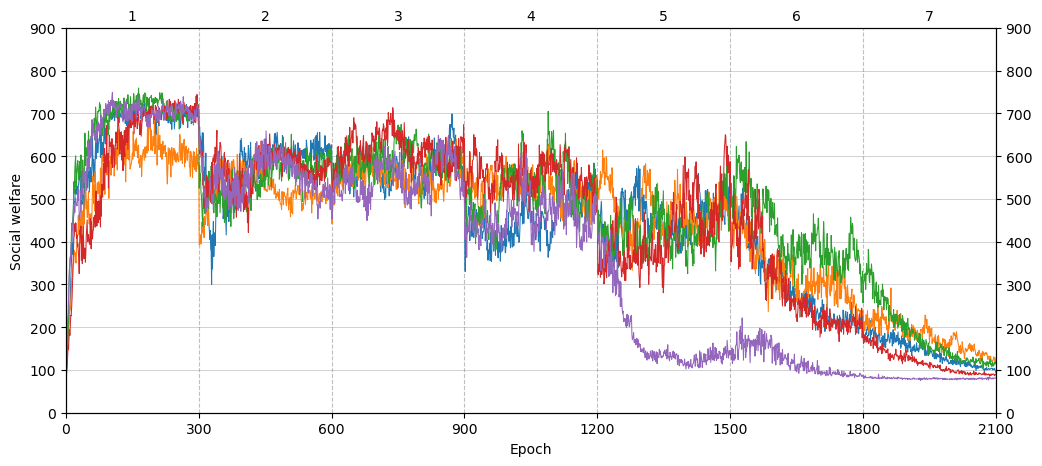

In [4]:
self_interest = 1
independent = True
rolling = False
environment = harvest

tids = environment['TRIAL_IDS_ID'] if independent else environment['TRIAL_IDS_SP']
df = pd.concat([load_df(t, environment=environment, independent=independent, self_interest=self_interest) for t in tids])

fig, ax = plot_num_players(df, rolling)

mode = 'independent' if independent else 'self_play'
if rolling:
    name += '_rolling'
fig.savefig(f'num_players_{mode}_{environment["name"]}', dpi=300, bbox_inches='tight')

In [5]:
def plot_self_interest(df, rolling: bool = False):
    grouped = df.groupby('trial_id')

    fig, ax = plt.subplots(figsize=(12, 5), facecolor='white')
    for name, group in grouped:
        if rolling:
            result = group['reward'].rolling(window=window, center=True).mean()
            indices = [list(range(epochs*i - window//2 + 1, epochs*i + window//2 +1)) for i in range(1, 10)]
            result.iloc[indices] = np.nan
            result.plot(ax=ax, label=name, legend=False, lw=0.75)
        else:
            group.plot(x='iteration', y='reward', ax=ax, label=name, legend=False, lw=0.75)
        
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Social welfare')
    ax.set_title(f'{n} players', y=1.05)
    ax.set_xlim(0, 3000)
    ax.set_ylim(0, 900)
    ax.set_xticks(np.arange(0, 3001, 300))
    ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='grey', alpha=0.5)
    ax.xaxis.grid(True, color='grey', linestyle='--', alpha=0.5)
    
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(ax.get_yticks())
    
    ratio = [20, 10, 5, 3, 5/2, 2, 5/3, 4/3, 1]
    regions = dict((f"{s:.2f}", (1+i) * 300) for i, s in enumerate([1] + [r/(n + r - 1) for r in ratio]))
    
    for region, position in regions.items():
        ax.text(position-150, 1.02, region, transform=ax.get_xaxis_transform(), horizontalalignment='center')

    return fig, ax


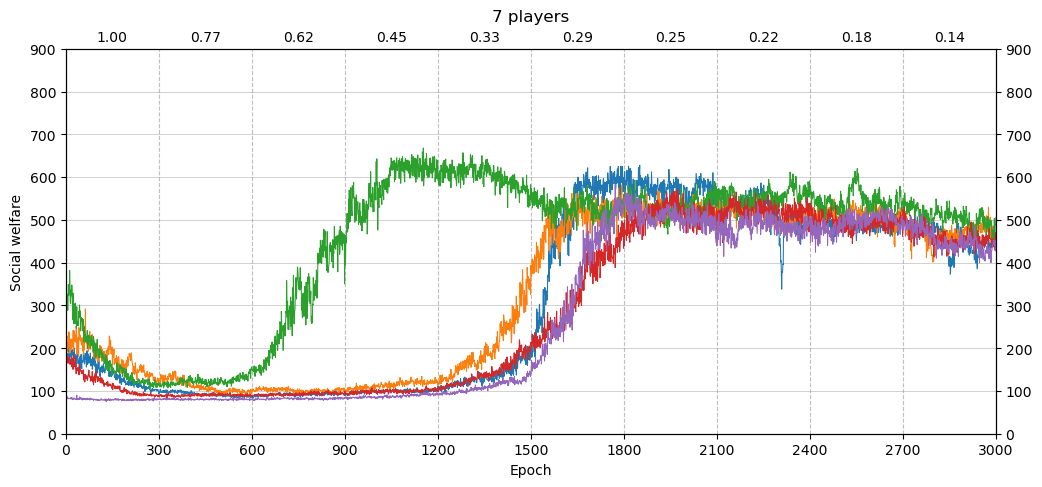

In [15]:
n = 7
independent = True
rolling = False
environment = harvest

tids = environment['TRIAL_IDS_ID'] if independent else environment['TRIAL_IDS_SP']
df = pd.concat([load_df(t, environment=environment, independent=independent, num_players=n) for t in tids])


fig, ax = plot_self_interest(df, rolling=rolling)

mode = 'independent' if independent else 'self_play'
fig.savefig(f'self_interest_{mode}_{n}_{environment["name"]}', dpi=300, bbox_inches='tight')

In [69]:
df

,self-interest,num_players,training-mode,reward,trial_id,iteration
0,1.000000,7,independent,187.633333,41697eb3,1
1,1.000000,7,independent,165.033333,41697eb3,2
2,1.000000,7,independent,179.966667,41697eb3,3
3,1.000000,7,independent,181.533333,41697eb3,4
4,1.000000,7,independent,175.333333,41697eb3,5
...,...,...,...,...,...,...
2995,0.142857,7,independent,441.033333,eb100aee,2996
2996,0.142857,7,independent,452.000000,eb100aee,2997
2997,0.142857,7,independent,427.733333,eb100aee,2998
2998,0.142857,7,independent,453.133333,eb100aee,2999


In [159]:
df[df['iteration'] % 300 == 0]

,self-interest,num_players,training-mode,reward,trial_id,iteration
299,1.000,7,independent,93.233,41697eb3,300
599,0.769,7,independent,87.800,41697eb3,600
899,0.625,7,independent,96.667,41697eb3,900
1199,0.455,7,independent,111.533,41697eb3,1200
1499,0.333,7,independent,180.667,41697eb3,1500
1799,0.294,7,independent,599.167,41697eb3,1800
2099,0.250,7,independent,564.167,41697eb3,2100
2399,0.217,7,independent,497.700,41697eb3,2400
2699,0.182,7,independent,519.667,41697eb3,2700
2999,0.143,7,independent,463.100,41697eb3,3000


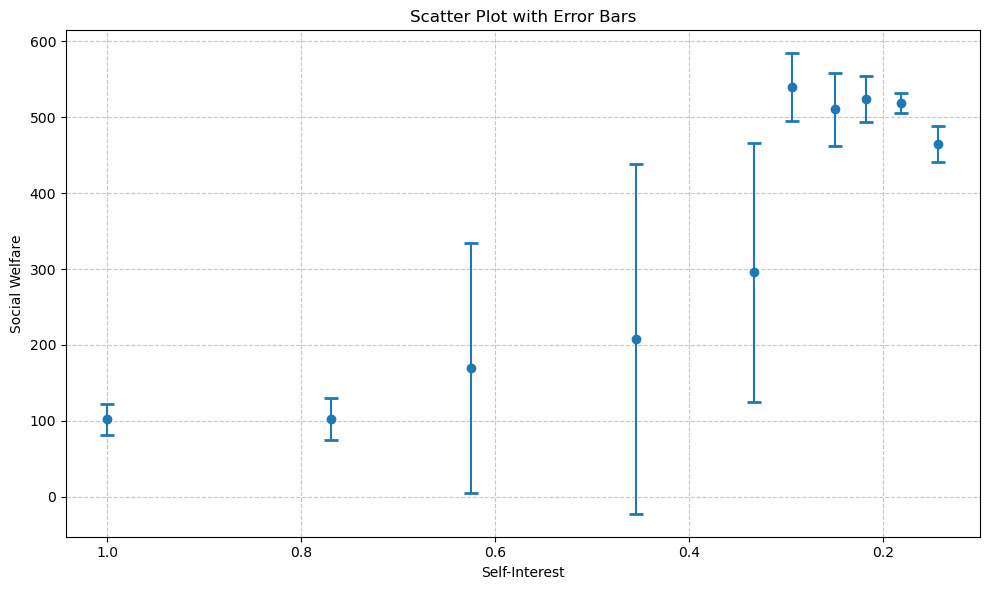

In [76]:
import matplotlib.pyplot as plt
import numpy as np

group = df[df['iteration'] % 300 == 0].groupby('iteration')

# Extract the data
x = group['self-interest'].mean()
y = group['reward'].mean()
yerr = group['reward'].std()

# Create the scatter plot with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=5, capthick=2)

# Set labels and title
plt.xlabel('Self-Interest')
plt.ylabel('Social Welfare')
plt.title('Scatter Plot with Error Bars')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Reverse the x-axis
plt.gca().invert_xaxis()

# Show the plot
plt.tight_layout()
plt.show()

In [158]:
group = df[df['iteration'] % 300 == 0].groupby('self-interest')
df2 = pd.DataFrame(dict((f'{name:.3f}', data.values) for name, data in group['reward']))
df2

,0.143,0.182,0.217,0.250,0.294,0.333,0.455,0.625,0.769,1.000
0,463.100,519.667,497.700,564.167,599.167,180.667,111.533,96.667,87.800,93.233
1,447.333,522.333,519.533,509.033,524.000,394.067,113.400,102.600,102.900,128.767
2,505.300,536.367,571.900,542.867,559.567,547.967,620.433,464.133,150.200,116.967
3,454.000,516.400,531.800,497.500,478.133,214.067,101.867,99.933,89.867,88.367
4,452.433,499.700,499.633,438.800,537.700,140.633,93.033,83.333,80.233,81.800


In [156]:
from scipy.stats import dunnett

best_group = df2[df2.mean().idxmax()]

data = pd.DataFrame({'mean': df2.mean(), 'std dev': df2.std(), 'dunnet': df2.apply(lambda x: dunnett(x, control=best_group, alternative='less').pvalue[0])}).T
# p values: the probability that we cannot reject the null hypothesis (the sample is not less than the control)
data

,0.143,0.182,0.217,0.250,0.294,0.333,0.455,0.625,0.769,1.000
mean,464.433,518.893,524.113,510.473,539.713,295.480,208.053,169.333,102.200,101.827
std dev,23.543,13.156,30.251,48.062,44.643,171.214,230.672,164.965,28.047,20.069
dunnet,0.005,0.173,0.268,0.174,0.500,0.007,0.007,0.001,0.000,0.000
